<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="##fincap---analysis" data-toc-modified-id="#fincap---analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>#fincap - analysis</a></span></li><li><span><a href="#Monthly-measures" data-toc-modified-id="Monthly-measures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monthly measures</a></span></li></ul></div>

# #fincap - analysis
Team GRFN

This Jupyter notebooks reads in `DailyMeasures.parquet` and `Expirations.parquet`, compute monthly measures from daily measures, and performs the statstical analysis.
The code outputs the file `Timeseries_monthly.pdf` which plots the time series of all monthly measures, the file `RegResult.tex` that contains a table with the estimation results, and `.tex` files under `Text_Python/` that contains the textual description of the statistical results to be included in the paper.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
df = pd.read_parquet('../Data/DailyMeasures_v3.parquet')
df.index.names = ['DATE', 'EXPIRATION']
df = df.sort_index()
df = df.reset_index()

# Get actual expiration dates
expirations = pd.read_parquet('../Data/Expirations.parquet')
df = pd.merge(df, expirations, on='EXPIRATION')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)

In [4]:
# Variables labels for output
cols = ['ABS_VR_30T5T', 'REAL_SPREAD_5T', 'CLIENTS_REAL_SPREAD_5T',
        'SHR_CLIENT_VOL', 'FRAC_CLIENTS_MKT', 'GTR']


# For titles
desc = {'ABS_VR_30T5T': 'Panel A: Variance ratio',
        'SHR_CLIENT_VOL': 'Panel C: Share of client volume in total volume',
        'REAL_SPREAD_5T': 'Panel B: Monthly average realized bid-ask spreads',
        'CLIENTS_REAL_SPREAD_5T': 'Panel D: Monthly average client realized bid-ask spreads',
        'FRAC_CLIENTS_MKT': 'Panel E: Fraction of client trades executed via market orders',
        'GTR': 'Panel F: Monthly average client gross trading revenue'}

# For y-labels
short_desc = {'ABS_VR_30T5T': 'Abs. VR(30, 5)',
              'SHR_CLIENT_VOL': 'Client share (\\%)',
              'REAL_SPREAD_5T': 'Realized spreads (bps)',
              'CLIENTS_REAL_SPREAD_5T': 'Client realized spreads (bps)',
              'FRAC_CLIENTS_MKT': 'Fraction (\\%)',
              'GTR': 'Gross trading revenue (bps)'}

# For description in the text
text_desc = {'ABS_VR_30T5T': 'market efficiency',
             'SHR_CLIENT_VOL': 'the share of client volume in total volume',
             'REAL_SPREAD_5T': 'the realized bid-ask spreads',
             'CLIENTS_REAL_SPREAD_5T': 'the realized bid-ask spreads for client trades',
             'FRAC_CLIENTS_MKT': 'the fraction of client trades executed via market orders and marketable limit orders',
             'GTR': 'the relative gross trading revenue for clients'}


# Variable names (in text)
var_desc = {'ABS_VR_30T5T': 'ABS_VR',
            'SHR_CLIENT_VOL': 'SHR_CLIENT_VOL',
            'REAL_SPREAD_5T': 'REAL_SPREAD',
            'CLIENTS_REAL_SPREAD_5T': 'CLIENTS_REAL_SPREAD',
            'FRAC_CLIENTS_MKT': 'FRAC_CLIENTS_MKT',
            'GTR': 'CLIENTS_GTR'}
# Latex-friendly
for v in var_desc:
    var_desc[v] = var_desc[v].replace('_', '\\_')

In [5]:
# Utility function for consistent plots
def clean_ax(ax, title=None, ylabel=None, xlabel='Date', ylim=None, xlim=None):
    if title is not None:
        ax.set_title(title, fontsize=14)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax

In [6]:
# Value-weighted average
def compute_vwavg(data, x, w, resample='M'):
    df = data[[x, w]].copy()
    df['W_' + x] = df[x] * df[w]
    vwavg = df[['W_' + x, w]].resample(resample).sum()
    vwavg = vwavg['W_' + x] / vwavg[w]
    vwavg.name = x
    return vwavg

# Average ratio
def compute_avg_ratio(data, denom, num, resample='M', name=None):
    df = data[[denom, num]].dropna().copy()
    ratio_sum = df.resample(resample).sum()
    avg_ratio = ratio_sum[denom] / ratio_sum[num]
    if name is not None:
        avg_ratio.name = name
    return avg_ratio

# Monthly measures

We next compute monthly metrics from daily data. To compute the monthly measures, we do the following:

- For the variance ratio, we use the simple average of daily variance ratio for the front-most contract.
- For all realized bid-ask spreads, we use the volume-weighted average over the month for the front-most contracts.
- For the share of client volume in total volume and the fraction of client trades executed via market orders and marketable limit orders, we re-compute monthly ratios using trade volume for all contracts.

When using frontmost contract, we roll over on the expiration date (i.e. we do not use the frontmost contract on the day it expires.).

In [7]:
frontmost = df[df.index != df.EXPIRATION_DATE].groupby(level=0).first()
frontmost
df

,EXPIRATION,ABS_VR_30T5T,SHR_CLIENT_VOL,TOTAL_QTY,CLIENTS_QTY,REAL_SPREAD_5T,REAL_SPREAD_5T_QTY,CLIENTS_REAL_SPREAD_5T,CLIENTS_REAL_SPREAD_5T_QTY,FRAC_CLIENTS_MKT,CLIENTS_MKT_QTY,GTR,GTR_VALUE,EXPIRATION_DATE
DATE,,,,,,,,,,,,,,
2002-01-02,200203,0.378002,0.447179,218702,97799.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-03-15
2002-01-03,200203,0.228655,0.474557,292304,138715.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-03-15
2002-01-04,200203,0.492619,0.439982,338148,148779.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-03-15
2002-01-07,200203,0.059260,0.401585,343818,138072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-03-15
2002-01-08,200203,0.067629,0.398775,355516,141771.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-17,201812,0.342622,0.235014,2479604,582742.0,-0.000077,1234598.0,0.000076,356626.0,0.410499,356626.0,0.000059,1.093817e+09,2018-12-21
2018-12-18,201812,0.056745,0.268440,2653890,712411.0,-0.000019,1314165.0,-0.000066,465813.0,0.424035,465813.0,0.000007,1.421521e+09,2018-12-21
2018-12-19,201812,0.198397,0.243069,2189246,532137.0,-0.000107,1081618.0,0.000027,338616.0,0.353162,338616.0,-0.000091,1.033035e+09,2018-12-21


In [8]:
# Keep only frontmost contract
frontmost = df[df.index != df.EXPIRATION_DATE].groupby(level=0).first()

# Variance ratio
vr_var = 'ABS_VR_30T5T'
vr = frontmost.resample('M')[vr_var].mean()

# Realized bid-ask spread
rs = compute_vwavg(frontmost, 'REAL_SPREAD_5T', 'REAL_SPREAD_5T_QTY', 'M')

# Realized bid-ask spread for clients
client_rs = compute_vwavg(frontmost, 'CLIENTS_REAL_SPREAD_5T', 'CLIENTS_REAL_SPREAD_5T_QTY', 'M')
# Compute weighted mean

# Share of client volume in total volume
shr_client_vol = compute_avg_ratio(df, 'CLIENTS_QTY', 'TOTAL_QTY', resample='M', name='SHR_CLIENT_VOL')

# Fraction of client trades executed via market orders and marketable limit orders
frac_clients_mkt = compute_avg_ratio(df, 'CLIENTS_MKT_QTY', 'CLIENTS_QTY', resample='M', name='FRAC_CLIENTS_MKT')

# Gross tradign revenue
gtr = compute_vwavg(frontmost, 'GTR', 'GTR_VALUE', 'M')

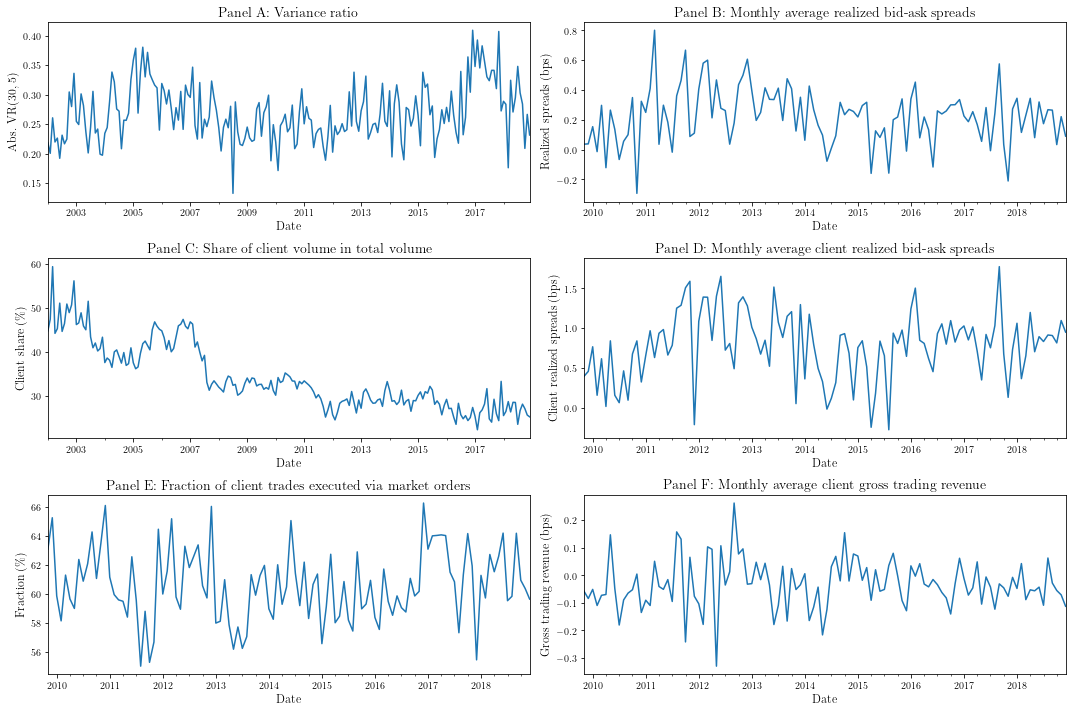

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))

ax = vr.plot(ax=axes[0][0])
ax = clean_ax(ax, title=desc['ABS_VR_30T5T'], ylabel=short_desc['ABS_VR_30T5T'])

ax = (100 * 100 * rs).dropna().plot(ax=axes[0][1])
ax = clean_ax(ax, title=desc['REAL_SPREAD_5T'], ylabel=short_desc['REAL_SPREAD_5T'])

ax = (100 * 100 * client_rs).dropna().plot(ax=axes[1][1])
ax = clean_ax(ax, title=desc['CLIENTS_REAL_SPREAD_5T'], ylabel=short_desc['CLIENTS_REAL_SPREAD_5T'])

ax = (100 * shr_client_vol).plot(ax=axes[1][0])
ax = clean_ax(ax, title=desc['SHR_CLIENT_VOL'], ylabel=short_desc['SHR_CLIENT_VOL'])

ax = (100 * frac_clients_mkt).plot(ax=axes[2][0])
ax = clean_ax(ax, title=desc['FRAC_CLIENTS_MKT'], ylabel=short_desc['FRAC_CLIENTS_MKT'])

ax = (100 * 100 * gtr).dropna().plot(ax=axes[2][1])
ax = clean_ax(ax, title=desc['GTR'], ylabel=short_desc['GTR'])

plt.tight_layout()
plt.savefig('../Paper/Figures/Timeseries_monthly.pdf')

In [10]:
# Combine in one clean monthly dataframe
monthly_df = pd.DataFrame([vr, rs, client_rs, shr_client_vol, frac_clients_mkt, gtr]).T

# Convert to logs
log_monthly_df = np.log(monthly_df)
# Time variable
log_monthly_df['T'] = (log_monthly_df.index.year - 2002) + (log_monthly_df.index.month / 12)

In [11]:
cols

['ABS_VR_30T5T',
 'REAL_SPREAD_5T',
 'CLIENTS_REAL_SPREAD_5T',
 'SHR_CLIENT_VOL',
 'FRAC_CLIENTS_MKT',
 'GTR']

In [12]:
# Estimate timeseries regressions
results = {}
for c in ['ABS_VR_30T5T',
          'REAL_SPREAD_5T',
          'SHR_CLIENT_VOL',
          'CLIENTS_REAL_SPREAD_5T',
          'FRAC_CLIENTS_MKT','GTR']:
    reg_res = smf.ols(data=log_monthly_df, formula=c + ' ~ T').fit(cov_type='HAC',
                                                                   cov_kwds={'maxlags': 6})
    res = {}
    res['Coef.'] = reg_res.params['T']
    res['Std. err.'] = reg_res.bse['T']
    res['$t$ stat.'] = reg_res.tvalues['T']
    res['$p$-value'] = reg_res.pvalues['T']
    res['C.I. lower bound'] = reg_res.conf_int()[0]['T']
    res['C.I. upper bound'] = reg_res.conf_int()[1]['T']
    results[c] = res
results = pd.DataFrame(results).T

reg_res = results.copy()

# Some formatting
def format_pval(x):
    if x < 0.001:
        return '$<$ 0.001'
    else:
        return f'{x:0.3f}'

results['$p$-value'] = results['$p$-value'].apply(format_pval)
results['$t$ stat.'] = results['$t$ stat.'].apply(lambda x: f'{x:0.3f}')
for c in [c for c in results.columns if c not in ['$p$-value', '$t$ stat.']]:
    results[c] = results[c].apply(lambda x: f'{x:0.3%}'.replace('%', '\%'))
results.index = results.index.map(var_desc)
results.to_latex('../Paper/Tables/RegResult.tex', escape=False)
results

,Coef.,Std. err.,$t$ stat.,$p$-value,C.I. lower bound,C.I. upper bound
ABS\_VR,0.531\%,0.449\%,1.182,0.237,-0.349\%,1.412\%
REAL\_SPREAD,-1.534\%,3.459\%,-0.444,0.657,-8.313\%,5.245\%
SHR\_CLIENT\_VOL,-3.723\%,0.270\%,-13.812,$<$ 0.001,-4.252\%,-3.195\%
CLIENTS\_REAL\_SPREAD,5.578\%,4.462\%,1.250,0.211,-3.166\%,14.323\%
FRAC\_CLIENTS\_MKT,0.059\%,0.192\%,0.309,0.757,-0.318\%,0.437\%
CLIENTS\_GTR,-4.914\%,4.647\%,-1.057,0.290,-14.023\%,4.194\%


In [13]:
# Text output for paper
for c in reg_res.index.values:
    out = 'We reject the null of no change. '
    signif = True
    if reg_res.loc[c, '$p$-value'] > 0.05:
        out = 'We do not reject the null of no change '
        signif = False
    # Variance ratio is inversely related to market efficiency 
    if c == 'ABS_VR_30T5T':
        if reg_res.loc[c, 'Coef.'] < 0:
            if signif:
                out += ('We find that ' + text_desc[c] + ' increased ')
            out += ('as our measure ' +
                    var_desc[c] + f' declined by {abs(reg_res.loc[c, "Coef."]):0.3%} ')
        else:
            if signif:
                out += ('We find that ' + text_desc[c] + ' declined ')
            out += ('as our measure ' +
                    var_desc[c] + f' increased by {abs(reg_res.loc[c, "Coef."]):0.3%} ')
    else:
        if reg_res.loc[c, 'Coef.'] < 0:
            if signif:
                out += ('We find that ' + text_desc[c] + ' declined ')
            out += ('as our measure ' +
                    var_desc[c] + f' declined by {abs(reg_res.loc[c, "Coef."]):0.3%} ')
        else:
            if signif:
                out += ('We find that ' + text_desc[c] + ' increased ')
            out += ('as our measure ' +
                    var_desc[c] + f' increased by {abs(reg_res.loc[c, "Coef."]):0.3%} ')
    out += f'on average per year where the standard error of this change is {reg_res.loc[c, "Std. err."]:0.3%} and the resulting $t$-statistic is {reg_res.loc[c, "$t$ stat."]:0.3f}'
    out += ' ($p$-value is ' + results.loc[var_desc[c], '$p$-value'] + ').'
    out = out.replace('%', '\%')
    
    with open('../Paper/Text_Python/' + c + '.tex', 'w') as f:
        f.write(out)
    print(out + '\n')

We do not reject the null of no change as our measure ABS\_VR increased by 0.531\% on average per year where the standard error of this change is 0.449\% and the resulting $t$-statistic is 1.182 ($p$-value is 0.237).

We do not reject the null of no change as our measure REAL\_SPREAD declined by 1.534\% on average per year where the standard error of this change is 3.459\% and the resulting $t$-statistic is -0.444 ($p$-value is 0.657).

We reject the null of no change. We find that the share of client volume in total volume declined as our measure SHR\_CLIENT\_VOL declined by 3.723\% on average per year where the standard error of this change is 0.270\% and the resulting $t$-statistic is -13.812 ($p$-value is $<$ 0.001).

We do not reject the null of no change as our measure CLIENTS\_REAL\_SPREAD increased by 5.578\% on average per year where the standard error of this change is 4.462\% and the resulting $t$-statistic is 1.250 ($p$-value is 0.211).

We do not reject the null of no chan